# Reducing discrepancy using retry strategy

## Initial Imports and Set-up


In [1]:
%matplotlib inline

import pylab
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import time



In [2]:
def sign(x):
    if x>=0:
        return 1.
    elif x<0:
        return -1.
    else:
        return None

In [68]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['lines.linewidth'] = 2.
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Proxima Nova']})
# # rc('font',**{'family':'serif','serif':['Times']})
# rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)



In [63]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Data Structure and Functions

### Node definition, Haar2d and Initialization of the tree

In [4]:
class Node(object):
    def __init__(self, xlims = np.array([]), ylims = np.array([]), split=0, isLeaf=False, isRoot=False):
#         self.nature = 'no-cross' # no-cross is for no split of intervals
        self.xlims = np.asarray(xlims)
        self.ylims = np.asarray(ylims)
        self.function = haar2d
        self.count = np.zeros(2)
        self.count[0] = 0. # 0 is for bottom-left one-fourth and diagonally opposite
        self.count[1] = 0. # 1 if for top-left and bottom-right
        
        # At max 4 children
        self.lx_child = None # left x
        self.rx_child = None # right x
        
        self.by_child = None  # bottom y
        self.ty_child = None  # top y
        self.isLeaf = isLeaf 
        self.isRoot = isRoot
        
        self.split = split # is either 0, 1, 2, denoting that either you split by splitting x or y or both
        self.rvs = []
        self.leaves = []
        
    def __str__(self, level=0):
        ret = "level "+str(level)+"\t"*level+str(self.xlims)+';'+str(self.ylims)+'; split ='+str(self.split)+'\n' #str(self.count[0])+':'+str(self.count[1])+
        if self.isLeaf:
            ret = 'leaf' + ret
        for child in [self.lx_child, self.rx_child, self.by_child, self.ty_child]:
            if child != None and level <=10:
                ret += child.__str__(level+1)
        return ret

def haar2d(num, xlims, ylims):
    '''
    returns 
    '''
    d = len(xlims)
    
    assert(len(num) == d)
    
    if d!=2:
        raise AssertionError("Issue with limits.")

    xlo = xlims[0]
    xhi = xlims[1]
    xmid = 0.5* (xlo + xhi) 
    ylo = ylims[0]
    yhi = ylims[1]
    ymid = 0.5* (ylo + yhi) 

    num_x = num[0]
    num_y = num[1]
    if (xlo <= num_x < xmid and ylo <= num_y < ymid):
        return 1, 0
    elif (xmid <= num_x < xhi  and ymid <= num_y < yhi ):
        return 3, 0
    elif (xmid <= num_x < xhi and ylo <= num_y < ymid):
        return 2, 1
    elif (xlo <= num_x < xmid  and ymid <= num_y < yhi ):
        return 4, 1
    else: 
        return None


### Updating the tree by splitting the leaves

In [5]:
def update_tree(root):
    """
    this updates the tree by splitting all leaves into two. It clears the root leaves
    and each update_leaf adds two leaves to root.leaves
    """
    if (not root.isRoot):
        raise AssertionError("No root tree. Please provide the root tree as well.")

    old_leaves = root.leaves
    root.leaves = [] # empty the leaves list
    
    for leaf in old_leaves:
        update_leaf(root, leaf) # each update will add two leaves in root.leaves

def update_leaf(root, leaf, forceroot=False):
    """
    this splits a leaf of the root tree in two parts, and appends to root.leaves
    the new leaves.
    """
    if not root.isRoot:
        raise AssertionError("No root tree. Please provide the root tree as well.")
    if (not forceroot and not leaf.isLeaf):
        raise AssertionError("This is not the leaf level, can not update it.")
    else:
        leaf.isLeaf = False
        compute_children(leaf)
        assign_children_rvs(root, leaf)

def compute_children(leaf):
    split = leaf.split
    leafx = leaf.xlims
    leafy = leaf.ylims
    
    x1 = leafx[0]
    x2 = 0.5*(leafx[0]+leafx[1])
    x3 = leafx[1]
    
    y1 = leafy[0]
    y2 = 0.5*(leafy[0]+leafy[1])
    y3 = leafy[1]
    
    # Splitting only x
    xl1 = np.array([x1, x2])
    xl2 = np.array([x2, x3])
    y_fix = np.array([y1, y3])
    
    children = []

    # splitting only y
    x_fix = np.array([x1, x3])

    yl3 = np.array([y1, y2])
    yl4 = np.array([y2, y3])
    
    if split == 1:
        leaf.by_child = Node(xlims = x_fix, ylims = yl3, split = 1, isLeaf=True, isRoot=False)
        leaf.ty_child = Node(xlims = x_fix, ylims = yl4, split = 1, isLeaf=True, isRoot=False)
#         children.append(Node(xlims = x_fix, ylims = yl3, split = 1, isLeaf=True, isRoot=False)) 
#         children.append(Node(xlims = x_fix, ylims = yl4, split = 1, isLeaf=True, isRoot=False)) 

    if split == 0:
        leaf.lx_child = Node(xlims = xl1, ylims = y_fix, split = 0, isLeaf=True, isRoot=False)
        leaf.rx_child = Node(xlims = xl2, ylims = y_fix, split = 0, isLeaf=True, isRoot=False)
#         children.append(Node(xlims = xl1, ylims = y_fix, split = 0, isLeaf=True, isRoot=False)) 
#         children.append(Node(xlims = xl2, ylims = y_fix, split = 0, isLeaf=True, isRoot=False)) 
    
    if split == 2:
        leaf.by_child = Node(xlims = x_fix, ylims = yl3, split = 2, isLeaf=True, isRoot=False)
        leaf.ty_child = Node(xlims = x_fix, ylims = yl4, split = 2, isLeaf=True, isRoot=False)
        leaf.lx_child = Node(xlims = xl1, ylims = y_fix, split = 0, isLeaf=True, isRoot=False)
        leaf.rx_child = Node(xlims = xl2, ylims = y_fix, split = 0, isLeaf=True, isRoot=False)
#         children.append(Node(xlims = x_fix, ylims = yl3, split = 2, isLeaf=True, isRoot=False)) 
#         children.append(Node(xlims = x_fix, ylims = yl4, split = 1, isLeaf=True, isRoot=False)) 
#         children.append(Node(xlims = xl1, ylims = y_fix, split = 0, isLeaf=True, isRoot=False)) 
#         children.append(Node(xlims = xl2, ylims = y_fix, split = 0, isLeaf=True, isRoot=False)) 
    
        
def assign_children_rvs(root, leaf):
    """
    this transfers the random variables of a (leaf) node to its children.
    """

    leaf.count[0] = 0.
    leaf.count[1] = 0.
    
    for num in leaf.rvs:
        quad, value = leaf.function(num, leaf.xlims, leaf.ylims)
        adjust_rv_leaf_child(leaf, quad, num)
        if value == None:
            raise AssertionError('Issues in rvs of the leaf, no valid value for haar')
        leaf.count[value] += 1

    for child in [leaf.lx_child, leaf.rx_child, leaf.by_child, leaf.ty_child]:
        if child != None:
            root.leaves.append(child)

def adjust_rv_leaf_child(leaf, quad, num):
    for child in return_child_idx(leaf, quad):
        append_rv_child(child, num)

def append_rv_child(node, num):
    if node == None:
        return
    else:
        node.rvs.append(num)

def return_child_idx(node, quad):
    if quad == 1:
        return [node.lx_child, node.by_child]
    elif quad == 2:
        return [node.rx_child, node.by_child]
    elif quad == 3:
        return [node.rx_child, node.ty_child]
    elif quad == 4:
        return [node.lx_child, node.ty_child]
    else:
        return []

In [6]:
def initialize_tree(depth = 1):
    '''
    creating a tree with certain depth to begin with. We need a tree with leaves for the code to work.
    '''
    root = Node(isLeaf=False, isRoot=True)
    root.xlims = np.array([0., 2.])
    root.ylims = np.array([0., 2.])
    
    child1 = Node(isLeaf=True, isRoot=False)
    child1.xlims = np.array([0., 1.])
    child1.ylims = np.array([0., 2.])
    child1.split = 0
    
    child2 = Node(isLeaf=True, isRoot=False)
    child2.xlims = np.array([0., 2.])
    child2.ylims = np.array([0., 1.])
    child2.split = 1
    
    root.lx_child = child1
    root.by_child = child2

    child = Node(xlims = [0., 1.], ylims = [0., 1.], split = 2, isLeaf=True, isRoot = False)
    root.rx_child  = child # This is arbitrary nomenclature
    
    root.leaves.append(child1)
    root.leaves.append(child2)
    root.leaves.append(child)
    
    for _ in range(depth-1):
        update_tree(root)
    return root

### Recursive insert and rate function

In [7]:
def insert(node, root, num, flag=False):
    ''' 
    this inserts a given number at leaf level in the root tree by 
    iteratively going down the nodes and comparing to their mval, 
    less than mval goes to the 'lchild' and increments 'lcount' of that
    node by 1, and otherwise, the number is passed to the 'rchild'
    and node's 'rcount' is incremented by 1.

    root tree is passed to keep track of the leaves at the global level
    '''
    if node == None:
        return
    if (not root.isRoot):
        raise AssertionError("No root tree. Please provide the root tree as well.")
    elif node.isLeaf == True:
        node.rvs.append(num)
        if not flag:
            root.rvs.append(num) # to maintain a global list of all random numbers so far
    elif node.isRoot:
        node.count[0] += 1
        insert(node.lx_child, root, num)
        flag = True
        insert(node.by_child, root, num, flag)
        insert(node.rx_child, root, num, flag)
    else:
        quad, value = node.function(num, node.xlims, node.ylims)
        # quad = 1, means the guy is passed to lx child and by child
        if value != None:
            node.count[value] += 1
            if quad == 1:
                insert(node.lx_child, root, num, flag)
                flag = 1
                insert(node.by_child, root, num, flag)
            elif quad == 2:
                insert(node.rx_child, root, num, flag)
                flag = 1
                insert(node.by_child, root, num, flag)
            elif quad == 3:
                insert(node.rx_child, root, num, flag)
                flag = 1
                insert(node.ty_child, root, num, flag)
            else:
                insert(node.lx_child, root, num, flag)
                flag = 1
                insert(node.ty_child, root, num, flag)
        else:
            print 'what the hell!!'
            return
def compute_rate_debug(node, num, num_har = 0., rate=0., eta=1., verbose=False):
    '''
    compute rate (Lambda in the paper) by iteratively going down a tree 
    and seeing the balance at each level. This returns the rate when
    the function has reached the leaf level.
    '''
    if node.isLeaf == True:
        return num_har, rate

    else:
        indicator = sign(node.count[0]-node.count[1]) # positive when count[0] is more
        quad, value = node.function(num, node.xlims, node.ylims)
        if value == None:
            raise AssertionError('Value Error in Compute_Rate')
        if value == 0: 
            indicator *= -1 # sign flip = discourage a number with value 0 if count[0] was more, encourage otherwise; 
                            # similarly discourage a number with value 1 if count[1] was more, encourage value 0 in this case
        if node.isRoot:
            rate += 0
            num_har += 0
        else:
            rate += indicator * eta / 10.
            num_har += 1 # count the number of times rate is incremented

        if verbose:
            print ('sign:%d, 0-1 = %d, sign = %d ' % (indicator, node.count[0]-node.count[1], sign(node.count[0]-node.count[1])) + ' num = '+str(num)
                        +'quad: %d, label: %d' %(quad, value)  + ' x:' + str(node.xlims) + ' y:' + str(node.ylims))
        if node.isRoot:
            node_children = [node.lx_child, node.by_child, node.rx_child] # last is NONE here
        else:
            node_children = return_child_idx(node, quad)
        for child in node_children:
            if child != None:
                num_har, rate = compute_rate_debug(child, num, num_har, rate, eta, verbose)

    return num_har, rate


In [8]:
root = initialize_tree(2)
for i in range(2):
    update_tree(root)
# print root
compute_rate_debug(root, [0.,  0.], verbose=True)

sign:-1, 0-1 = 0, sign = 1  num = [0.0, 0.0]quad: 1, label: 0 x:[ 0.  2.] y:[ 0.  2.]
sign:-1, 0-1 = 0, sign = 1  num = [0.0, 0.0]quad: 1, label: 0 x:[ 0.  1.] y:[ 0.  2.]
sign:-1, 0-1 = 0, sign = 1  num = [0.0, 0.0]quad: 1, label: 0 x:[ 0.   0.5] y:[ 0.  2.]
sign:-1, 0-1 = 0, sign = 1  num = [0.0, 0.0]quad: 1, label: 0 x:[ 0.    0.25] y:[ 0.  2.]
sign:-1, 0-1 = 0, sign = 1  num = [0.0, 0.0]quad: 1, label: 0 x:[ 0.  2.] y:[ 0.  1.]
sign:-1, 0-1 = 0, sign = 1  num = [0.0, 0.0]quad: 1, label: 0 x:[ 0.  2.] y:[ 0.   0.5]
sign:-1, 0-1 = 0, sign = 1  num = [0.0, 0.0]quad: 1, label: 0 x:[ 0.  2.] y:[ 0.    0.25]
sign:-1, 0-1 = 0, sign = 1  num = [0.0, 0.0]quad: 1, label: 0 x:[ 0.  1.] y:[ 0.  1.]
sign:-1, 0-1 = 0, sign = 1  num = [0.0, 0.0]quad: 1, label: 0 x:[ 0.   0.5] y:[ 0.  1.]
sign:-1, 0-1 = 0, sign = 1  num = [0.0, 0.0]quad: 1, label: 0 x:[ 0.    0.25] y:[ 0.  1.]
sign:-1, 0-1 = 0, sign = 1  num = [0.0, 0.0]quad: 1, label: 0 x:[ 0.  1.] y:[ 0.   0.5]
sign:-1, 0-1 = 0, sign = 1  num = 

(12.0, -1.2)

### Everything needed for discrepancy

In [9]:
def retry(num, rate, eta=1.):
    '''
    retry strategy as given in the paper.
    '''
    num = np.asarray(num)
    u = np.random.rand()
    if u <= rate-eta/2:
        return num
    else:
        return np.random.rand(num.shape[0])

def greedy_retry(num, rate, eta=1.):
    '''
    greedy strategy
    '''    
    num = np.asarray(num)
    # Binary decision
    if rate>1: 
        return num
    else:
        return np.random.rand(num.shape[0])

def simple(num, rate, eta=1.):
    return num

def update_count(count, num, interval):
    '''
    updates the number of points inside a d-dimensional interval d by 2
    '''
    ind = True
    for j in range(len(interval)): # == interval.shape[0]
        if num[j] < interval[j][0] or num[j] >= interval[j][1]:
            ind = False
    if (ind):
        count += 1
    return count

def random_insert(root, num, method, verbose=False, eta=1.):
    '''
    this uses the rate to first compute the adjusted rate and then use this rate 
    and the given number to get a number from retry strategy which is inserted in the tree.

    Note that this function should use depth = log2(len(root.leaves))
    and rate = 1. (the initial rate)
    '''
    if (not root.isRoot):
        raise AssertionError("No root tree. Please provide the root tree as well.")
    rate = 0.
    if method  != simple:
        den, rate = compute_rate_debug(node=root, num=num, eta=eta, num_har = 0., rate=0.)
        rate = 1. + rate/den
        num_to_insert = method(num, rate, eta)
    else:
        num_to_insert = num
    if verbose:
        print rate, num, num_to_insert
    insert(root, root, num_to_insert)
    
    return num_to_insert

def update_discrepancy(interval, count, root, num, method=retry, verbose = False, eta=1.):
    '''
    interval is a d by 2 matrix, where the column[0] contains the lower limit for each 
    dimension and column[1] denotes the upper limit for the interval
    
    method can be retry, simple or greedy
    '''
    num_inserted = random_insert(root, num, method, verbose=False, eta=1.)
    count = update_count(count, num_inserted, interval)
    return count, len(root.rvs), num_inserted
    

In [10]:
def update_two_choice_discrepancy(interval, count, root, num1, num2, verbose = False, eta=1.):
    '''
    interval is a d by 2 matrix, where the column[0] contains the lower limit for each 
    dimension and column[1] denotes the upper limit for the interval
    
    method can be retry, simple or greedy
    '''
    num_inserted = two_choice_insert(root, num1, num2, verbose=verbose, eta=1.)
    count = update_count(count, num_inserted, interval)
    return count, len(root.rvs), num_inserted 

def two_choice_insert(root, num1, num2, verbose=False, eta=1.):
    '''
    this uses the rate to first compute the adjusted rate and then use this rate 
    and the given number to get a number from retry strategy which is inserted in the tree.

    Note that this function should use depth = log2(len(root.leaves))
    and rate = 1. (the initial rate)
    '''
    if (not root.isRoot):
        raise AssertionError("No root tree. Please provide the root tree as well.")
        
    den1, rate1 = compute_rate_debug(node=root, num=num1, eta=eta, num_har = 0., rate=0.)
    den2, rate2 = compute_rate_debug(node=root, num=num2, eta=eta, num_har = 0., rate=0.)
    
    rate1 = 1. + rate1/den1
    rate2 = 1. + rate2/den2
    
    num_to_insert = num1
    
    if rate2 > rate1:
        num_to_insert = num2
    elif rate2 == rate1:
        if np.random.rand() <0.5:
            num_to_insert = num2
    if verbose:
        print rate1, num1, rate2, num2, num_to_insert
    insert(root, root, num_to_insert)
    return num_to_insert

In [11]:
print retry([0., 0.2], 0.32, 1)

dim = 2
initial_depth = 3
final_depth = 8
interval = [[0, 0.5], [0, 0.5]] # First brackets denote the xlims, and second bracket shows the ylims
volume = np.asarray([(interval[j][1]-interval[j][0]) for j in range(dim)])
volume = np.prod(volume)

[ 0.   0.2]


In [12]:
volume
xx = np.random.rand(2)
yy = np.random.rand(2)

x1 = np.min(xx)
x2 = np.max(xx)

y1 = np.min(yy)
y2 = np.max(yy)

interval2 = [[x1, x2], [y1, y2]]
print interval2

[[0.042629641235554683, 0.4513987085082235], [0.2283420996896609, 0.31123444999890415]]


## Main Simulation : Uniform Distribution in 2D

In [13]:
## Set the seed
np.random.seed(127368)

## Set the params and the interval
dim = 2

interval = [[0, 0.5], [0, 0.5]] # First brackets denote the xlims, and second bracket shows the ylims
volume = np.asarray([(interval[j][1]-interval[j][0]) for j in range(dim)])
volume = np.prod(volume)

interval2 = [[0., 2./3], [0., 2./3]] # First brackets denote the xlims, and second bracket shows the ylims
volume2 = np.asarray([(interval2[j][1]-interval2[j][0]) for j in range(dim)])
volume2 = np.prod(volume2)

## Settings for depth and repetitions
initial_depth = 3
final_depth = 10
num_depths = final_depth-initial_depth + 1
num_exp = 20

N = final_depth+1

my_dis = np.zeros((num_exp, N*2**(N+1)))
t_dis = np.zeros((num_exp, N*2**(N+1)))
u_dis = np.zeros((num_exp, N*2**(N+1)))
g_dis = np.zeros((num_exp, N*2**(N+1)))

my_dis2 = np.zeros((num_exp, N*2**(N+1)))
t_dis2 = np.zeros((num_exp, N*2**(N+1)))
u_dis2 = np.zeros((num_exp, N*2**(N+1)))
g_dis2 = np.zeros((num_exp, N*2**(N+1)))

# my_unif = np.zeros((num_exp, N*2**(N+1)))
# t_unif = np.zeros((num_exp, N*2**(N+1)))
# u_unif = np.zeros((num_exp, N*2**(N+1)))
# g_unif = np.zeros((num_exp, N*2**(N+1)))

n_dis = np.zeros((num_exp, N*2**(N+1)))

for exp in range(num_exp):
    print '\n ========= %d-dimensional case,  Experiment Number:%d =========' % (dim, exp+1)
    
    r_root = initialize_tree(initial_depth)
    g_root = initialize_tree(initial_depth)# to see the greedy
#     u_root = initialize_tree(initial_depth)# to see the balance of urvs
    t_root = initialize_tree(initial_depth)# to see the two choice greedy performance

#     urvs = []
#     urvs = np.asarray(urvs)
    
    r_count = 0.
    r_count2 = 0.
    
    u_count = 0.
    u_count2 = 0.
    
    g_count = 0.
    g_count2 =0.
    
    t_count = 0.
    t_count2 =0.
    
    idx = 0
    total_g = 0
    total_n = 0
    total_u = 0
    total_t = 0
    
    t0 = time.time()
    for i in range(num_depths):
        j = initial_depth+i
        n0 = j*2**j

        rvs = np.random.rand(n0, 2)
        rvs2 = np.random.rand(n0, 2)
#         urvs = np.concatenate((urvs, rvs))

        for rv, rv2 in zip(rvs, rvs2):
            r_count, total_n, num = update_discrepancy(interval, r_count, r_root, num=rv, method=retry, verbose = False, eta=1.)
            r_count2 = update_count(r_count2, num, interval2)
            
            g_count, total_g, num_g = update_discrepancy(interval, g_count, g_root, num=rv, method=greedy_retry,
                                                         verbose = False, eta=1.)
            g_count2 = update_count(g_count2, num_g, interval2)
            
#             u_count, total_u, num_u = update_discrepancy(interval, u_count, u_root, num=rv, method=simple, 
#                                                          verbose = False, eta=1.)
            total_u = total_n
            num_u = rv
            u_count = update_count(u_count, num_u, interval)
            u_count2 = update_count(u_count2, num_u, interval2)
            
            t_count, total_t, num_t = update_two_choice_discrepancy(interval, t_count, t_root, num1=rv, num2=rv2, 
                                                         verbose = False, eta=1.)
            t_count2 = update_count(t_count2, num_t, interval2)
            
            assert(total_n == total_u)
            assert(total_n == total_g)
            assert(total_n == total_t)
            
            my_dis[exp, idx] = np.abs(float(r_count)/total_n-volume)
            g_dis[exp, idx] = np.abs(float(g_count)/total_g-volume)
            u_dis[exp, idx] = np.abs(float(u_count)/total_u-volume)
            t_dis[exp, idx] = np.abs(float(t_count)/total_u-volume)
            
            my_dis2[exp, idx] = np.abs(float(r_count2)/total_n-volume2)
            g_dis2[exp, idx] = np.abs(float(g_count2)/total_g-volume2)
            u_dis2[exp, idx] = np.abs(float(u_count2)/total_u-volume2)
            t_dis2[exp, idx] = np.abs(float(t_count2)/total_u-volume2)
            
            n_dis[exp, idx] = total_u

            idx += 1
            
        update_tree(r_root)
        update_tree(g_root)
#         update_tree(u_root)


        print 'level %d -- \t n: %d, my_dis: %f, g_dis: %f, t_dis:%f, u_dis: %f' % (j, n_dis[exp, idx-1], 
                                                                     my_dis[exp, idx-1], 
                                                                    g_dis[exp, idx-1], 
                                                                    t_dis[exp, idx-1],
                                                                    u_dis[exp, idx-1])
        t1 = time.time()
        t = t1-t0
        t0 = t1

        print 'level %d -- \t n: %d, my_dis: %f, g_dis: %f, t_dis:%f, u_dis: %f, time taken: %.2f \n' % (j, n_dis[exp, idx-1], 
                                                                     my_dis2[exp, idx-1], 
                                                                    g_dis2[exp, idx-1],
                                                                    t_dis2[exp, idx-1],
                                                                    u_dis2[exp, idx-1], t)



 ========= 2-dimensional case,  Experiment Number:1 =========
level 3 -- 	 n: 24, my_dis: 0.125000, g_dis: 0.041667, t_dis:0.000000, u_dis: 0.041667
level 3 -- 	 n: 24, my_dis: 0.236111, g_dis: 0.069444, t_dis:0.027778, u_dis: 0.027778, time taken: 0.01 

level 4 -- 	 n: 88, my_dis: 0.022727, g_dis: 0.011364, t_dis:0.000000, u_dis: 0.045455
level 4 -- 	 n: 88, my_dis: 0.058081, g_dis: 0.012626, t_dis:0.021465, u_dis: 0.001263, time taken: 0.05 

level 5 -- 	 n: 248, my_dis: 0.080645, g_dis: 0.008065, t_dis:0.008065, u_dis: 0.064516
level 5 -- 	 n: 248, my_dis: 0.099910, g_dis: 0.015233, t_dis:0.011201, u_dis: 0.079749, time taken: 0.18 

level 6 -- 	 n: 632, my_dis: 0.026899, g_dis: 0.004747, t_dis:0.004747, u_dis: 0.022152
level 6 -- 	 n: 632, my_dis: 0.025492, g_dis: 0.007736, t_dis:0.006153, u_dis: 0.020745, time taken: 0.62 

level 7 -- 	 n: 1528, my_dis: 0.001309, g_dis: 0.000000, t_dis:0.001309, u_dis: 0.003272
level 7 -- 	 n: 1528, my_dis: 0.002691, g_dis: 0.003200, t_dis:0.003

In [23]:
# Averaging across experiments

my_dis = my_dis[:, 1:idx]
u_dis = u_dis[:, 1:idx]
g_dis = g_dis[:, 1:idx]
t_dis = t_dis[:, 1:idx]
n_dis = n_dis[:, 1:idx]

avg_my_dis = np.mean(my_dis, axis=0)
avg_u_dis = np.mean(u_dis, axis=0)
avg_t_dis = np.mean(t_dis, axis=0)
avg_g_dis = np.mean(g_dis, axis=0)
avg_n_dis = np.mean(n_dis, axis=0)

my_dis2 = my_dis2[:, 1:idx]
u_dis2 = u_dis2[:, 1:idx]
g_dis2 = g_dis2[:, 1:idx]
t_dis2 = t_dis2[:, 1:idx]

avg_my_dis2 = np.mean(my_dis2, axis=0)
avg_u_dis2 = np.mean(u_dis2, axis=0)
avg_t_dis2 = np.mean(t_dis2, axis=0)
avg_g_dis2 = np.mean(g_dis2, axis=0)
avg_n_dis2 = np.mean(n_dis, axis=0)


### Save the results for further processing

In [16]:
import pickle

with open('2d_dis_and_rvs.pickle', 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump([r_root.rvs, g_root.rvs, t_root.rvs, avg_my_dis, avg_u_dis, 
                 avg_g_dis, avg_t_dis, avg_my_dis2, avg_u_dis2, 
                 avg_g_dis2, avg_t_dis2, avg_n_dis], f)

## Plots

In [34]:
# # Load the results
with open('2d_dis_and_rvs.pickle') as f:  # Python 3: open(..., 'rb')
    [r_rvs, g_rvs, t_rvs, avg_my_dis, avg_u_dis, 
    avg_g_dis, avg_t_dis, avg_my_dis2, avg_u_dis2, 
    avg_g_dis2, avg_t_dis2, avg_n_dis]  = pickle.load(f)


array([ True,  True], dtype=bool)

In [87]:
import matplotlib as mpl
label_size = 60
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['legend.fontsize'] = 50
pylab.rcParams['xtick.major.pad']=8
pylab.rcParams['ytick.major.pad']=8




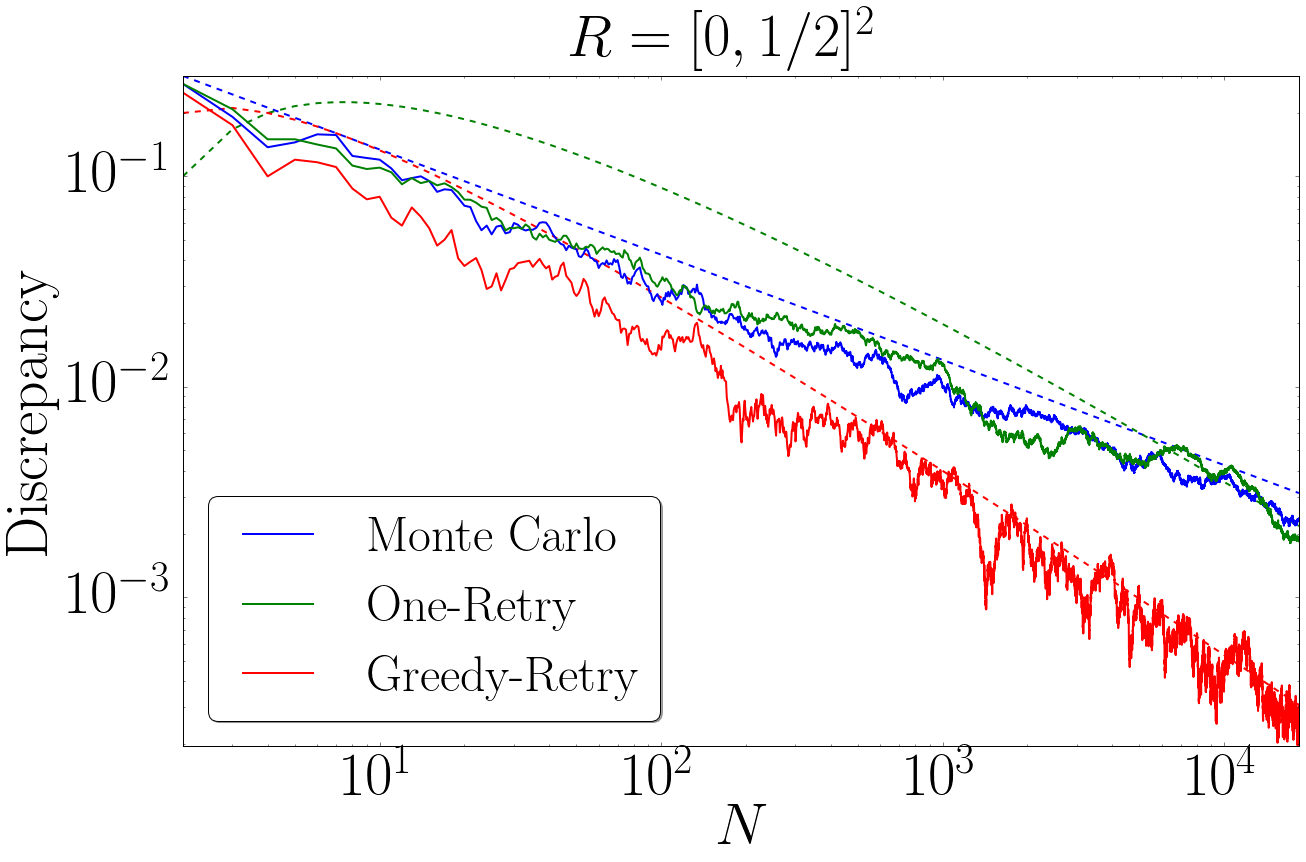

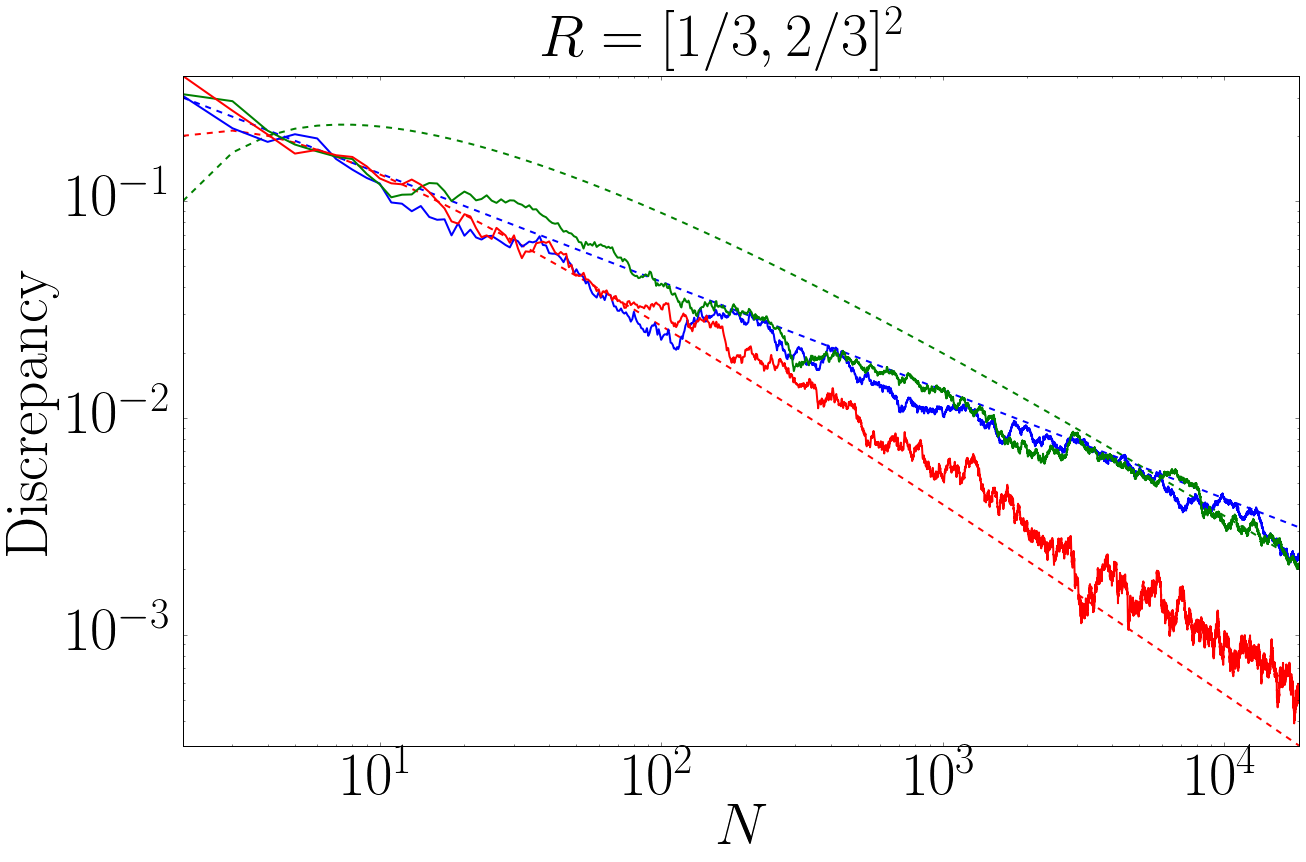

In [89]:
# Plotting Discrepancy
fig = plt.figure(figsize=[20,12])



# base line:
y0 = np.sqrt(avg_n_dis[0])
y = 0.3*y0 / np.sqrt(avg_n_dis)
plt.plot(avg_n_dis, y, 'b--', linewidth=2.)

y0 = avg_n_dis[0]/(np.log2(avg_n_dis[0])**2)
y = 0.1*y0 /avg_n_dis * ((np.log2(avg_n_dis)**2) )
plt.plot(avg_n_dis, y, 'g--', linewidth=2.)


y0 = avg_n_dis[0]/(np.log2(avg_n_dis[0])**1)
y = 0.2*y0 /avg_n_dis * ((np.log2(avg_n_dis)**1) )
plt.plot(avg_n_dis, y, 'r--', linewidth=2.)


line, = plt.plot(avg_n_dis, avg_u_dis, linewidth=2.)
line.set_label('Monte Carlo')
line, = plt.plot(avg_n_dis, avg_my_dis, linewidth=2.)
line.set_label('One-Retry')
line, = plt.plot(avg_n_dis, avg_g_dis, linewidth=2.)
line.set_label('Greedy-Retry')
# line, = plt.plot(avg_n_dis, avg_t_dis, 'm', linewidth=1.)
# line.set_label('Two-Choice Greedy Retry')


plt.yscale('log')
plt.xscale('log')
plt.legend(loc='lower left', frameon=True, fancybox=True, shadow=0.5)
plt.axis('tight')
ax = fig.gca()
ax.set_ylabel(r'Discrepancy', fontsize = 60, labelpad=8)
ax.set_xlabel(r'$N', fontsize = 60, labelpad=-5)
plt.suptitle(r'$R=[0, 1/2]^2$', fontsize=60)



fig.savefig('../../plots/2d/2d-rates-1-2.pdf')
######### Now interval 2

fig = plt.figure(figsize=[20,12])

# base line:
y0 = np.sqrt(avg_n_dis[0])
y = 0.3*y0 / np.sqrt(avg_n_dis)
plt.plot(avg_n_dis, y, 'b--', linewidth=2.)

y0 = avg_n_dis[0]/(np.log2(avg_n_dis[0])**2)
y = 0.1*y0 /avg_n_dis * ((np.log2(avg_n_dis)**2) )
plt.plot(avg_n_dis, y, 'g--', linewidth=2.)


y0 = avg_n_dis[0]/(np.log2(avg_n_dis[0])**1)
y = 0.2*y0 /avg_n_dis * ((np.log2(avg_n_dis)**1) )
plt.plot(avg_n_dis, y, 'r--', linewidth=2.)


line, = plt.plot(avg_n_dis, avg_u_dis2, linewidth=2.)
line.set_label('Monte Carlo')
line, = plt.plot(avg_n_dis, avg_my_dis2, linewidth=2.)
line.set_label('One-Retry')
line, = plt.plot(avg_n_dis, avg_g_dis2, linewidth=2.)
line.set_label('Greedy-Retry')
# line, = plt.plot(avg_n_dis, avg_t_dis2, 'm', linewidth=1.)
# line.set_label('Two-Choice Greedy Retry')

plt.yscale('log')
plt.xscale('log')
# plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=0.5)
plt.axis('tight')
ax = fig.gca()
ax.set_ylabel(r'Discrepancy', fontsize = 60, labelpad=8)
ax.set_xlabel(r'$N', fontsize = 60, labelpad=-5)
plt.suptitle(r'$R=[1/3, 2/3]^2$', fontsize=60)

fig.savefig('../../plots/2d/2d-rates-1-3.pdf')



# Scatter Plot

In [154]:
def scatter_plot(xx, yy, S):
    ax.scatter(xx, yy, s=S)
    axes = plt.gca()
    axes.set_xlim([0.,1.])
    axes.set_ylim([0.,1.])
    plt.axis('off')


In [175]:
FS = [13, 6]
S = 100
num_points = [1000]

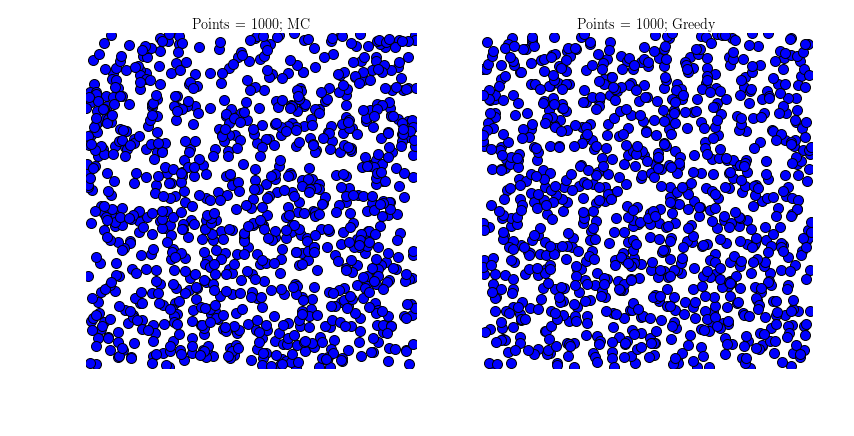

In [176]:
fig = plt.figure(figsize=FS)
for i, points in enumerate(num_points):
    zz = np.random.rand(points, 2)
    xx,yy = zz[:,0], zz[:, 1]
    ax = fig.add_subplot(1,2,i+1)
    scatter_plot(xx, yy, S)
    plt.title('Points = %d; MC' % (points))
    
#     zz = np.asarray(r_root.rvs[:points])
#     xx,yy = zz[:,0], zz[:, 1]
#     ax = fig.add_subplot(1,3,1+ i+1)
#     scatter_plot(xx, yy, S)
#     plt.title('Points = %d; Retry' % (points))

    zz = np.asarray(g_root.rvs[:points])
    xx,yy = zz[:,0], zz[:, 1]
    ax = fig.add_subplot(1,2,2+i)
    scatter_plot(xx, yy, S)
    plt.title('Points = %d; Greedy' % (points))

plt.show()

In [111]:
# zz = np.asarray(r_root.rvs[1:4])
print zz
print zz[:, 0]

[[ 0.75642397  0.85370473]
 [ 0.82180935  0.48293131]
 [ 0.58276372  0.63872638]
 ..., 
 [ 0.24581448  0.65682457]
 [ 0.15379538  0.55228586]
 [ 0.43874694  0.56058886]]
[  7.56423974e-01   8.21809347e-01   5.82763715e-01   1.89462740e-01
   2.68153552e-01   5.52160555e-01   4.33939077e-01   9.48729328e-01
   8.55065283e-01   3.85956910e-01   1.46350941e-01   1.91272840e-01
   7.30208904e-01   3.26180476e-01   5.77770806e-01   3.98416828e-01
   7.27105258e-03   6.83797906e-01   3.64206220e-01   5.80454101e-01
   6.63825209e-01   8.10951877e-01   2.53726178e-01   8.73391025e-01
   5.93826174e-01   8.69751093e-01   7.39531565e-01   8.19393360e-01
   4.65649117e-01   5.44870115e-01   6.62413613e-01   8.05207413e-01
   6.18117996e-01   1.39629879e-01   8.60115018e-01   7.00557749e-03
   8.59111200e-01   6.17837319e-01   2.16182773e-01   1.61624830e-01
   5.13700252e-01   8.09041021e-01   9.53863417e-01   6.41380407e-01
   4.78054412e-01   6.97268831e-01   5.00648769e-01   5.89487243e-01
  

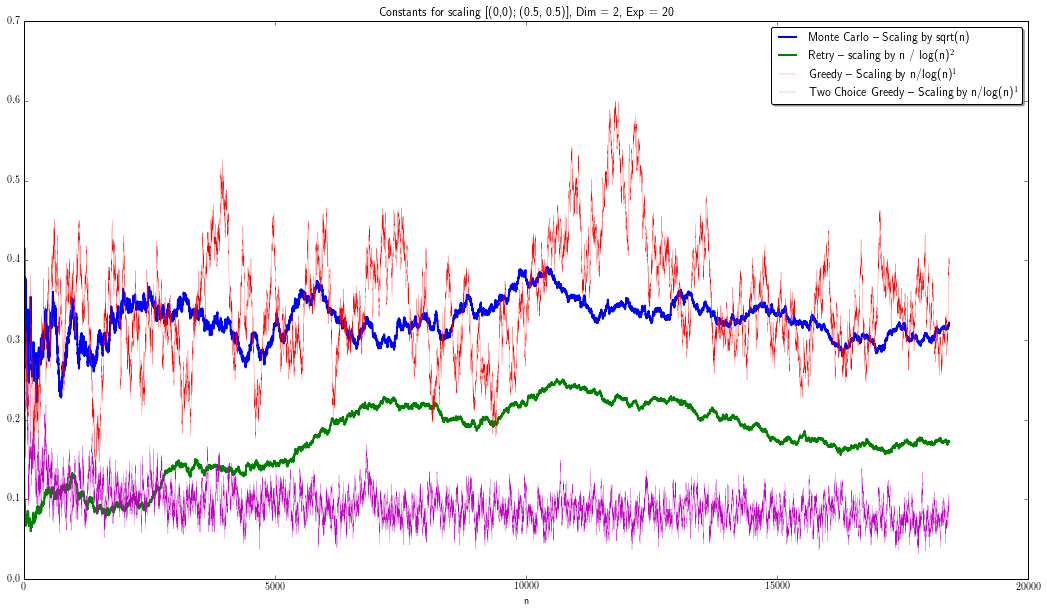

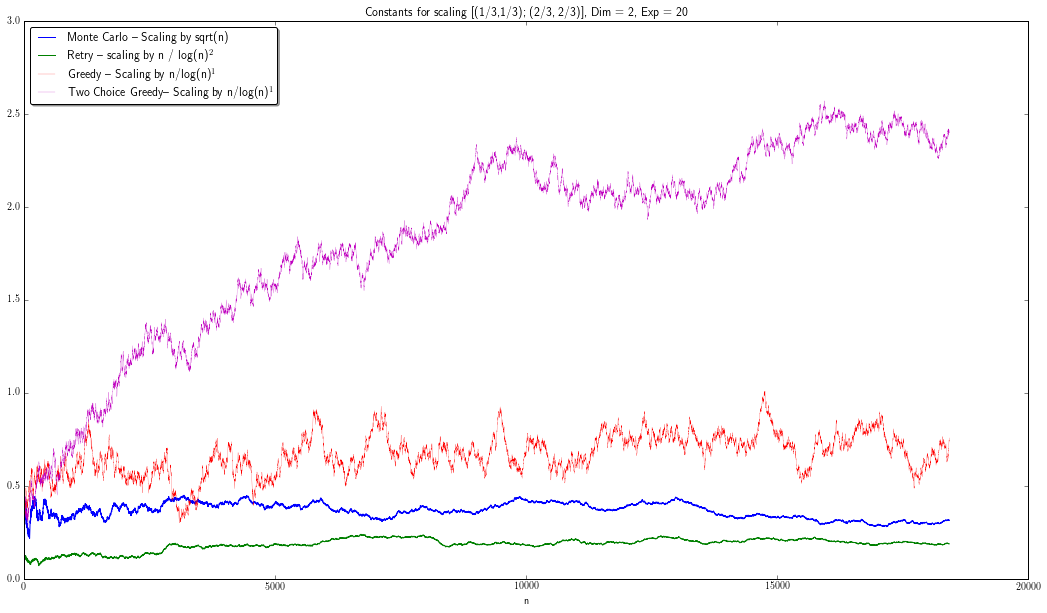

In [36]:
fig = plt.figure(figsize=[18,10])

y = avg_u_dis * np.sqrt(avg_n_dis)
line, = plt.plot(avg_n_dis, y, 'b', linewidth=2.)
line.set_label('Monte Carlo -- Scaling by sqrt(n)')


y = avg_my_dis * avg_n_dis/ (np.log2(avg_n_dis)**2)
line, = plt.plot(avg_n_dis, y, 'g', linewidth=2.)
line.set_label('Retry -- scaling by n / log(n)^2 ')


y = avg_g_dis * avg_n_dis/ (np.log2(avg_n_dis)**1)
line, = plt.plot(avg_n_dis, y, 'r', linewidth=0.2)
line.set_label('Greedy -- Scaling by n/log(n)^1 ')

y = avg_t_dis * avg_n_dis/ (np.log2(avg_n_dis)**1)
line, = plt.plot(avg_n_dis, y, 'm', linewidth=0.2)
line.set_label('Two Choice Greedy -- Scaling by n/log(n)^1 ')


plt.legend(loc='best', frameon=True, fancybox=True, shadow=0.5)
plt.xlabel('n')
plt.title('Constants for scaling [(0,0); (0.5, 0.5)], Dim = %d, #Exp = %d' % (dim ,num_exp))


### 

fig = plt.figure(figsize=[18,10])

y = avg_u_dis2 * np.sqrt(avg_n_dis)
line, = plt.plot(avg_n_dis, y, 'b', linewidth=1.)
line.set_label('Monte Carlo -- Scaling by sqrt(n)')


y = avg_my_dis2 * avg_n_dis/ (np.log2(avg_n_dis)**2)
line, = plt.plot(avg_n_dis, y, 'g', linewidth=1.)
line.set_label('Retry -- scaling by n / log(n)^2 ')


y = avg_g_dis2 * avg_n_dis/ (np.log2(avg_n_dis)**1)
line, = plt.plot(avg_n_dis, y, 'r', linewidth=.2)
line.set_label('Greedy -- Scaling by n/log(n)^1 ')

y = avg_t_dis2 * avg_n_dis/ (np.log2(avg_n_dis)**1)
line, = plt.plot(avg_n_dis, y, 'm', linewidth=0.2)
line.set_label('Two Choice Greedy-- Scaling by n/log(n)^1 ')

plt.legend(loc='best', frameon=True, fancybox=True, shadow=0.5)
plt.xlabel('n')
plt.title('Constants for scaling [(1/3,1/3); (2/3, 2/3)], Dim = %d, #Exp = %d' % (dim ,num_exp))


# fig.savefig('constants.pdf')

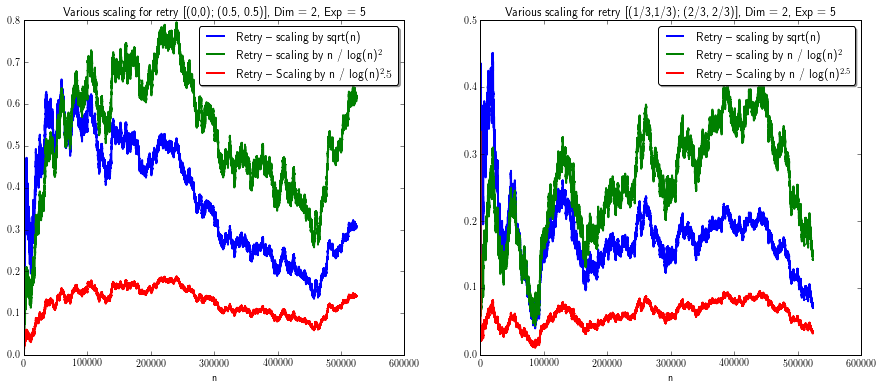

In [29]:
fig = plt.figure(figsize=[15,6])

plt.subplot(121)

# y = avg_my_dis * avg_n_dis/ (np.log2(avg_n_dis)**1)
# line, = plt.plot(avg_n_dis, y, 'b', linewidth=2.)
# line.set_label('Retry -- scaling by n / log(n)^1 ')

y = avg_my_dis * np.sqrt(avg_n_dis)
line, = plt.plot(avg_n_dis, y, 'b', linewidth=2.)
line.set_label('Retry -- scaling by sqrt(n)')


y = avg_my_dis * avg_n_dis/ (np.log2(avg_n_dis)**2)
line, = plt.plot(avg_n_dis, y, 'g', linewidth=2.)
line.set_label('Retry -- scaling by n / log(n)^2 ')


y = avg_my_dis * avg_n_dis/ (np.log2(avg_n_dis)**2.5)
line, = plt.plot(avg_n_dis, y, 'r', linewidth=2.)
line.set_label('Retry -- Scaling by n / log(n)^2.5 ')


plt.legend(loc='best', frameon=True, fancybox=True, shadow=0.5)
plt.xlabel('n')
plt.title('Various scaling for retry [(0,0); (0.5, 0.5)], Dim = %d, #Exp = %d' % (dim ,num_exp))


### 

plt.subplot(122)

# y = avg_my_dis2 * avg_n_dis/ (np.log2(avg_n_dis)**1)
# line, = plt.plot(avg_n_dis, y, 'b', linewidth=2.)
# line.set_label('Retry -- scaling by n / log(n)^1 ')

y = avg_my_dis2 * np.sqrt(avg_n_dis)
line, = plt.plot(avg_n_dis, y, 'b', linewidth=2.)
line.set_label('Retry -- scaling by sqrt(n)')


y = avg_my_dis2 * avg_n_dis/ (np.log2(avg_n_dis)**2)
line, = plt.plot(avg_n_dis, y, 'g', linewidth=2.)
line.set_label('Retry -- scaling by n / log(n)^2 ')


y = avg_my_dis2 * avg_n_dis/ (np.log2(avg_n_dis)**2.5)
line, = plt.plot(avg_n_dis, y, 'r', linewidth=2.)
line.set_label('Retry -- Scaling by n / log(n)^{2.5} ')



plt.legend(loc='best', frameon=True, fancybox=True, shadow=0.5)
plt.xlabel('n')
plt.title('Various scaling for retry [(1/3,1/3); (2/3, 2/3)], Dim = %d, #Exp = %d' % (dim ,num_exp))


# fig.savefig('images/rep500.pdf')

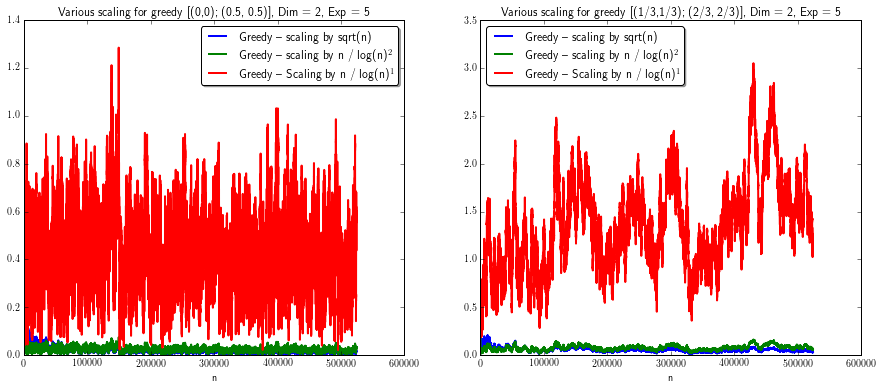

In [25]:
fig = plt.figure(figsize=[15,6])

plt.subplot(121)

y = avg_g_dis * np.sqrt(avg_n_dis)
line, = plt.plot(avg_n_dis, y, 'b', linewidth=2.)
line.set_label('Greedy -- scaling by sqrt(n) ')


y = avg_g_dis * avg_n_dis/ (np.log2(avg_n_dis)**2)
line, = plt.plot(avg_n_dis, y, 'g', linewidth=2.)
line.set_label('Greedy -- scaling by n / log(n)^2 ')


y = avg_g_dis * avg_n_dis/ (np.log2(avg_n_dis)**1)
line, = plt.plot(avg_n_dis, y, 'r', linewidth=2.)
line.set_label('Greedy -- Scaling by n / log(n)^1 ')


plt.legend(loc='best', frameon=True, fancybox=True, shadow=0.5)
plt.xlabel('n')
plt.title('Various scaling for greedy [(0,0); (0.5, 0.5)], Dim = %d, #Exp = %d' % (dim ,num_exp))


### 

plt.subplot(122)

y = avg_g_dis2 * np.sqrt(avg_n_dis)
line, = plt.plot(avg_n_dis, y, 'b', linewidth=2.)
line.set_label('Greedy -- scaling by sqrt(n) ')


y = avg_g_dis2 * avg_n_dis/ (np.log2(avg_n_dis)**2)
line, = plt.plot(avg_n_dis, y, 'g', linewidth=2.)
line.set_label('Greedy -- scaling by n / log(n)^2 ')


y = avg_g_dis2 * avg_n_dis/ (np.log2(avg_n_dis)**1)
line, = plt.plot(avg_n_dis, y, 'r', linewidth=2.)
line.set_label('Greedy -- Scaling by n / log(n)^1 ')



plt.legend(loc='best', frameon=True, fancybox=True, shadow=0.5)
plt.xlabel('n')
plt.title('Various scaling for greedy [(1/3,1/3); (2/3, 2/3)], Dim = %d, #Exp = %d' % (dim ,num_exp))


# fig.savefig('images/rep500.pdf')

### Additional Constants for comparison

In [ ]:
# fig = plt.figure(figsize=[15,6])

# plt.subplot(121)

# y = avg_u_dis * np.sqrt(avg_n_dis)
# line, = plt.plot(avg_n_dis, y, 'b', linewidth=2.)
# line.set_label('MC -- scaling by sqrt(n)')


# y = avg_u_dis * avg_n_dis/ (np.log2(avg_n_dis)**2)
# line, = plt.plot(avg_n_dis, y, 'g', linewidth=2.)
# line.set_label('MC -- scaling by n / log(n)^2 ')


# y = avg_u_dis * avg_n_dis/ (np.log2(avg_n_dis)**3)
# line, = plt.plot(avg_n_dis, y, 'r', linewidth=2.)
# line.set_label('MC -- Scaling by n / log(n)^3 ')

# plt.legend(loc='best', frameon=True, fancybox=True, shadow=0.5)
# plt.xlabel('n')
# plt.title('Various scaling for MC [0, 0.5), Dim = %d, #Exp = %d' % (dim ,num_exp))


# ### 

# plt.subplot(122)

# y = avg_u_dis2 * np.sqrt(avg_n_dis)
# line, = plt.plot(avg_n_dis, y, 'b', linewidth=2.)
# line.set_label('MC -- scaling by sqrt(n)')


# y = avg_u_dis2 * avg_n_dis/ (np.log2(avg_n_dis)**2)
# line, = plt.plot(avg_n_dis, y, 'g', linewidth=2.)
# line.set_label('MC -- scaling by n / log(n)^2 ')


# y = avg_u_dis2 * avg_n_dis/ (np.log2(avg_n_dis)**3)
# line, = plt.plot(avg_n_dis, y, 'r', linewidth=2.)
# line.set_label('MC -- Scaling by n / log(n)^3 ')



# plt.legend(loc='best', frameon=True, fancybox=True, shadow=0.5)
# plt.xlabel('n')
# plt.title('Various scaling for MC [1/3, 2/3), Dim = %d, #Exp = %d' % (dim ,num_exp))


# # fig.savefig('images/rep500.pdf')

In [ ]:
# fig = plt.figure(figsize=[15,6])

# plt.subplot(121)
# y = avg_u_dis * np.sqrt(avg_n_dis)
# line, = plt.plot(avg_n_dis, y, 'b', linewidth=2.)
# line.set_label('Monte Carlo -- Scaling by sqrt(n)')


# y = avg_my_dis * np.sqrt(avg_n_dis)
# line, = plt.plot(avg_n_dis, y, 'g', linewidth=2.)
# line.set_label('Retry -- Scaling by sqrt(n) ')


# y = avg_g_dis * np.sqrt(avg_n_dis)
# line, = plt.plot(avg_n_dis, y, 'r', linewidth=2.)
# line.set_label('Greedy -- Scaling by sqrt(n) ')


# plt.legend(loc='best', frameon=True, fancybox=True, shadow=0.5)
# plt.xlabel('n')
# plt.title('Constants for scaling [(0,0); (0.5, 0.5)], Dim = %d, #Exp = %d' % (dim ,num_exp))


# ### 

# plt.subplot(122)

# y = avg_u_dis2 * np.sqrt(avg_n_dis)
# line, = plt.plot(avg_n_dis, y, 'b', linewidth=2.)
# line.set_label('Monte Carlo -- Scaling by sqrt(n)')


# y = avg_my_dis2 *  np.sqrt(avg_n_dis)
# line, = plt.plot(avg_n_dis, y, 'g', linewidth=2.)
# line.set_label('Retry -- Scaling by sqrt(n) ')


# y = avg_g_dis2 *  np.sqrt(avg_n_dis)
# line, = plt.plot(avg_n_dis, y, 'r', linewidth=2.)
# line.set_label('Greedy -- Scaling by sqrt(n) ')


# plt.legend(loc='best', frameon=True, fancybox=True, shadow=0.5)
# plt.xlabel('n')
# plt.title('Constants for scaling [(1/3,1/3); (2/3, 2/3)], Dim = %d, #Exp = %d' % (dim ,num_exp))


# # fig.savefig('images/rep500.pdf')